1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

import gradio as gr

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
# 2.1 Specify columns to read
usecols = [
    'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'Referee',
    'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR',
    'B365H', 'B365D', 'B365A', 'B365>2.5', 'B365<2.5'
]

file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 21-22.csv"
df = pd.read_csv(file_path, usecols=usecols)

# 2.2 Assign a sequential MatchIndex and compute Round number
df['MatchIndex'] = df.index + 1
df['Round'] = np.ceil(df['MatchIndex'] / 10).astype(int)

# 2.3 Extract hour from kickoff Time and bucket into Morning/Afternoon/Evening
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins = [-1, 11, 17, 24]
labels = ['Morning', 'Afternoon', 'Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

# 2.4 Define the regression target:
#     - TotalGoals = sum of home and away full-time goals
#     - LogGoals  = log1p(TotalGoals) so that subsequent models predict on a log scale
df['TotalGoals'] = df['FTHG'] + df['FTAG']
df['LogGoals'] = np.log1p(df['TotalGoals'])

print("Loaded shape:", df.shape)
df.head()

Loaded shape: (380, 29)


,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,...,B365H,B365D,B365A,B365>2.5,B365<2.5,MatchIndex,Round,TimeOfDay,TotalGoals,LogGoals
0,20:00,Brentford,Arsenal,2,0,H,M Oliver,8,22,3,...,4.00,3.40,1.95,2.10,1.72,1,1,Evening,2,1.098612
1,12:30,Man United,Leeds,5,1,H,P Tierney,16,10,8,...,1.53,4.50,5.75,1.61,2.30,2,1,Afternoon,6,1.945910
2,15:00,Burnley,Brighton,1,2,A,D Coote,14,14,3,...,3.10,3.10,2.45,2.50,1.53,3,1,Afternoon,3,1.386294
3,15:00,Chelsea,Crystal Palace,3,0,H,J Moss,13,4,6,...,1.25,5.75,13.00,1.80,2.00,4,1,Afternoon,3,1.386294
4,15:00,Everton,Southampton,3,1,H,A Madley,14,6,6,...,1.90,3.50,4.00,2.00,1.80,5,1,Afternoon,4,1.609438


3. Leakage-Free Feature Engineering

In [3]:
# 3.1 Map full-time result to numeric Outcome (Home=1, Draw=0, Away=-1)
df['Outcome'] = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})

# 3.2 Calculate implied probabilities from Bet365 odds and normalize per row
for side in ['H', 'D', 'A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H', 'ImpProb_D', 'ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

# Over/Under 2.5
df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5', 'ImpUnder2.5']] = (
    df[['ImpOver2.5', 'ImpUnder2.5']]
      .div(df[['ImpOver2.5', 'ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Compute odds spread (Home odds minus Away odds)
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form for Home/Away (shifted to use only past data)
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/Loss streaks for Home/Away (shifted)
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.eq(1).shift(1).fillna(0).astype(int)
                    .groupby((~s.eq(1)).cumsum()).cumsum())
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.eq(-1).shift(1).fillna(0).astype(int)
                    .groupby((~s.eq(-1)).cumsum()).cumsum())
)

# 3.6 Interaction term between odds spread and home form
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias: ratio of past home wins called by this referee
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins', 'RefMatches'], inplace=True)

# 3.8 Head-to-head last result (signed for home team)
df['PairKey'] = df.apply(lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1)
h2h = {}
def prev_h2h(row):
    key  = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns=['PairKey'], inplace=True)

# 3.9 Rolling averages of match stats (shots, fouls, cards)
home_stats = ['HS', 'HST', 'HF', 'HC', 'HY', 'HR']
away_stats = ['AS', 'AST', 'AF', 'AC', 'AY', 'AR']

for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# 3.10 Previous-round table positions
df['HomePts'] = np.where(df['FTR'] == 'H', 3,
                 np.where(df['FTR'] == 'D', 1, 0))
df['AwayPts'] = np.where(df['FTR'] == 'A', 3,
                 np.where(df['FTR'] == 'D', 1, 0))

pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],   df['AwayPts']])
})

round_pts = (
    pts
    .groupby(['Team', 'Round'], as_index=False)['Pts']
    .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos']    = (
    round_pts
    .groupby('Round')['CumPts']
    .rank(method='min', ascending=False)
)

prev = round_pts[['Team', 'Round', 'Pos']].copy()
prev.rename(columns={'Round': 'PrevRound', 'Pos': 'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

df = df.merge(
    prev,
    left_on=['HomeTeam', 'Round'],
    right_on=['Team', 'PrevRound'],
    how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team', 'PrevRound', 'PrevPos'], inplace=True)

df = df.merge(
    prev,
    left_on=['AwayTeam', 'Round'],
    right_on=['Team', 'PrevRound'],
    how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team', 'PrevRound', 'PrevPos'], inplace=True)

# 3.11 Home/Away previous-position difference
df['PosDiff'] = df['HomePosPrev'] - df['AwayPosPrev']

4. Pipeline Specification

In [4]:
# 4.1 Define categorical and numeric feature lists (include PosDiff from step 3.11)
cat_feats = [
    'HomeTeam', 'AwayTeam', 'Referee', 'TimeOfDay'
]

num_feats = [
    'HomeForm3', 'AwayForm3',
    'HomeStreak', 'AwayStreak',
    'ImpProb_H', 'ImpProb_D', 'ImpProb_A',
    'ImpOver2.5', 'ImpUnder2.5',
    'OddsSpread', 'Spread×Form',
    'RefBias', 'H2H_Last',
    'HomePosPrev', 'AwayPosPrev',
    'PosDiff'
] + [f'Home_{stat}_3' for stat in home_stats] \
  + [f'Away_{stat}_3' for stat in away_stats]

# 4.2 Impute any remaining NaNs in numeric features
df[num_feats] = df[num_feats].fillna(0)

# 4.3 Build a ColumnTransformer to scale numeric features and one‐hot encode categoricals
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats),
], remainder='drop')

# 4.4 Pipeline factory: wrap a KNN regressor in a log‐transformed target regressor
def make_model(n_neighbors=12):
    """
    Returns a Pipeline that:
      - applies the preprocessor
      - fits a KNeighborsRegressor on log(1 + y)
      - back-transforms predictions with exp(y) - 1
    """
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    log_knn = TransformedTargetRegressor(
        regressor=knn,
        func=np.log1p,
        inverse_func=np.expm1
    )
    return Pipeline([
        ('prep', preprocessor),
        ('reg',  log_knn)
    ])

5. Round-by-Round Training & Prediction

In [5]:
# initialize containers for predictions and metadata
preds            = []
preds_rounded    = []
actuals          = []
rounds           = []
match_indices    = []

# number of initial matches to “warm up” the model
warmup = 50

# 5.1 Initial warm‐up fit on the first `warmup` matches
model = make_model()
model.fit(
    df.loc[:warmup-1, cat_feats + num_feats],
    df.loc[:warmup-1, 'TotalGoals']
)

# 5.2 Sequentially train on all matches before round r and predict on round r
for r in range(6, df['Round'].max() + 1):
    train_idx = df['Round'] < r
    test_idx  = df['Round'] == r

    X_train = df.loc[train_idx, cat_feats + num_feats]
    y_train = df.loc[train_idx, 'TotalGoals']

    X_test  = df.loc[test_idx, cat_feats + num_feats]
    y_test  = df.loc[test_idx, 'TotalGoals']

    # retrain the KNN pipeline from scratch each round
    model = make_model()
    model.fit(X_train, y_train)

    # predictions (already back‐transformed to original scale)
    y_pred = model.predict(X_test)

    # collect raw, rounded, actuals, round number, and match index
    preds.extend(y_pred.tolist())
    preds_rounded.extend(np.rint(y_pred).astype(int).tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_test))
    match_indices.extend(df.loc[test_idx, 'MatchIndex'].tolist())

print(f"Finished predicting rounds 6 to {df['Round'].max()}")

# 5.3 Save the final KNN model for the Gradio interface
final_model = model

Finished predicting rounds 6 to 38


6. Assemble & Save Results

In [6]:
# 6.1 Create a fast lookup by MatchIndex
df_idx = df.set_index('MatchIndex')

# 6.2 Collect Home/Away teams for each prediction
homes = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
aways = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

# 6.3 Build the results DataFrame with actual vs. predicted total goals
results_df = pd.DataFrame({
    'MatchIndex':             match_indices,
    'Round':                  rounds,
    'HomeTeam':               homes,
    'AwayTeam':               aways,
    'ActualGoals':            actuals,
    'PredictedGoals':         preds,
    'PredictedGoalsRounded':  preds_rounded
})

# 6.4 Save to disk (Excel)
output_path = r"D:\python\premier league predictor\predictions_vs_actuals_goals_knn.xlsx"
results_df.to_excel(output_path, index=False)
print("Results written to", output_path)

Results written to D:\python\premier league predictor\predictions_vs_actuals_goals_knn.xlsx


7. Results & Visualization

C:\Users\markf\AppData\Local\Temp\ipykernel_26840\1964520284.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


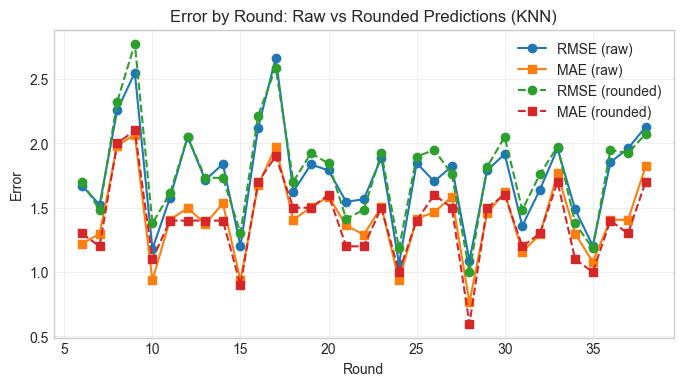

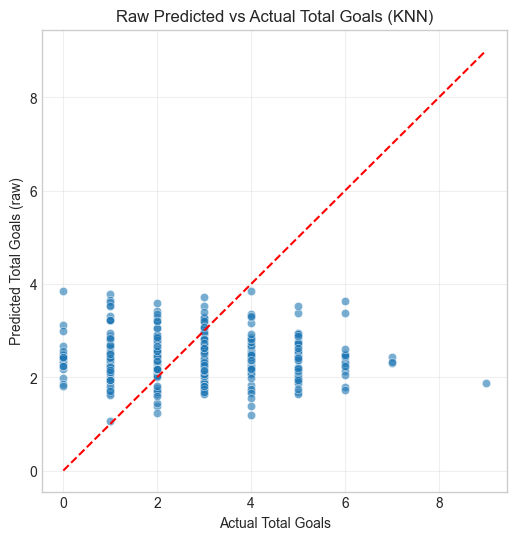

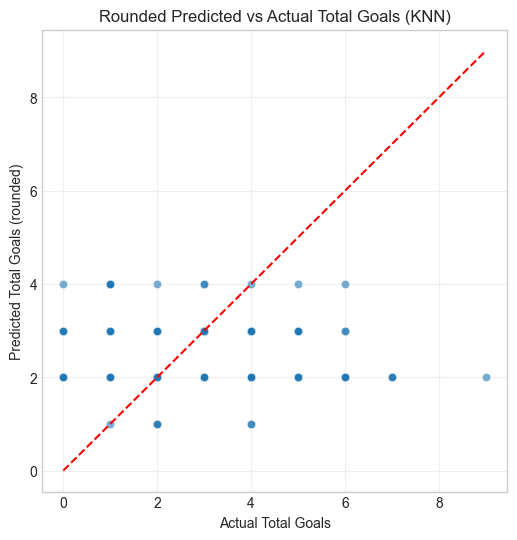

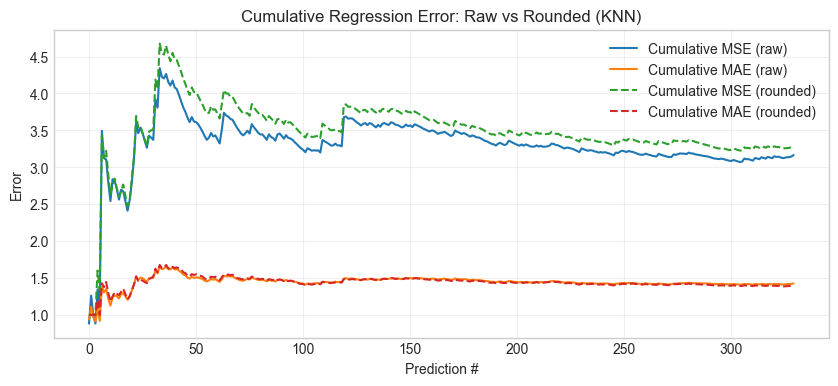

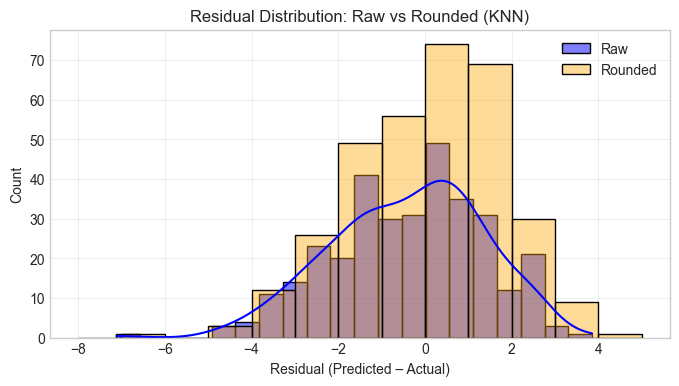

Over/Under 2.5 accuracy: 50.00%


In [7]:
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 7.1 Prepare DataFrame of predictions vs. actuals
res = pd.DataFrame({
    'Round':       rounds,
    'Pred':        preds,
    'PredRounded': preds_rounded,
    'True':        actuals
})

# 7.2 Compute round-by-round RMSE & MAE for raw and rounded predictions
round_stats = (
    res
    .groupby('Round')
    .apply(lambda g: pd.Series({
        'RMSE_raw':      np.sqrt(mean_squared_error(g['True'], g['Pred'])),
        'MAE_raw':       mean_absolute_error(g['True'], g['Pred']),
        'RMSE_round':    np.sqrt(mean_squared_error(g['True'], g['PredRounded'])),
        'MAE_round':     mean_absolute_error(g['True'], g['PredRounded'])
    }))
    .reset_index()
)

# 7.3 Plot RMSE & MAE by round (raw vs rounded)
plt.figure(figsize=(8, 4))
plt.plot(round_stats['Round'], round_stats['RMSE_raw'],     marker='o', label='RMSE (raw)')
plt.plot(round_stats['Round'], round_stats['MAE_raw'],      marker='s', label='MAE (raw)')
plt.plot(round_stats['Round'], round_stats['RMSE_round'],   marker='o', linestyle='--', label='RMSE (rounded)')
plt.plot(round_stats['Round'], round_stats['MAE_round'],    marker='s', linestyle='--', label='MAE (rounded)')
plt.xlabel('Round')
plt.ylabel('Error')
plt.title('Error by Round: Raw vs Rounded Predictions (KNN)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 7.4 Scatter plot: Predicted vs Actual (raw)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=res['True'], y=res['Pred'], alpha=0.6)
lims = [
    min(res['True'].min(), res['Pred'].min()),
    max(res['True'].max(), res['Pred'].max())
]
plt.plot(lims, lims, 'r--')
plt.xlabel('Actual Total Goals')
plt.ylabel('Predicted Total Goals (raw)')
plt.title('Raw Predicted vs Actual Total Goals (KNN)')
plt.grid(alpha=0.3)
plt.show()

# 7.5 Scatter plot: Predicted vs Actual (rounded)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=res['True'], y=res['PredRounded'], alpha=0.6)
lims = [
    min(res['True'].min(), res['PredRounded'].min()),
    max(res['True'].max(), res['PredRounded'].max())
]
plt.plot(lims, lims, 'r--')
plt.xlabel('Actual Total Goals')
plt.ylabel('Predicted Total Goals (rounded)')
plt.title('Rounded Predicted vs Actual Total Goals (KNN)')
plt.grid(alpha=0.3)
plt.show()

# 7.6 Cumulative MSE & MAE over all predictions
cum_mse_raw   = [mean_squared_error(actuals[:i], preds[:i])          for i in range(1, len(preds)+1)]
cum_mae_raw   = [mean_absolute_error(actuals[:i], preds[:i])         for i in range(1, len(preds)+1)]
cum_mse_round = [mean_squared_error(actuals[:i], preds_rounded[:i])  for i in range(1, len(preds_rounded)+1)]
cum_mae_round = [mean_absolute_error(actuals[:i], preds_rounded[:i]) for i in range(1, len(preds_rounded)+1)]

plt.figure(figsize=(10, 4))
plt.plot(cum_mse_raw,   label='Cumulative MSE (raw)')
plt.plot(cum_mae_raw,   label='Cumulative MAE (raw)')
plt.plot(cum_mse_round, linestyle='--', label='Cumulative MSE (rounded)')
plt.plot(cum_mae_round, linestyle='--', label='Cumulative MAE (rounded)')
plt.xlabel('Prediction #')
plt.ylabel('Error')
plt.title('Cumulative Regression Error: Raw vs Rounded (KNN)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 7.7 Residual distributions (raw vs rounded)
residuals_raw   = np.array(preds) - np.array(actuals)
residuals_round = np.array(preds_rounded) - np.array(actuals)

plt.figure(figsize=(8, 4))
sns.histplot(residuals_raw,   bins=20, kde=True,  color='blue',  label='Raw')
sns.histplot(residuals_round, bins=range(int(residuals_round.min())-1,
                                         int(residuals_round.max())+2),
             kde=False, color='orange', alpha=0.4, label='Rounded')
plt.xlabel('Residual (Predicted – Actual)')
plt.title('Residual Distribution: Raw vs Rounded (KNN)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 7.8 Accuracy for Over/Under 2.5 goals prediction
from sklearn.metrics import accuracy_score

# create binary labels
true_over = (res['True'] > 2.5).astype(int)
pred_over = (res['Pred'] > 2.5).astype(int)

# compute accuracy
ou_accuracy = accuracy_score(true_over, pred_over)
print(f"Over/Under 2.5 accuracy: {ou_accuracy:.2%}")


8. Gradio Interface

In [8]:
import gradio as gr

# 8.1 Precompute historical means of odds-derived features
odd_feats = [
    'ImpProb_H', 'ImpProb_D', 'ImpProb_A',
    'ImpOver2.5', 'ImpUnder2.5', 'OddsSpread'
]
odd_means = df[odd_feats].mean()

# 8.2 Dropdown options for the UI
teams = sorted(df['HomeTeam'].unique())
refs  = sorted(df['Referee'].unique())
times = ['Morning', 'Afternoon', 'Evening']

# 8.3 Prediction function using the final KNN model
def predict_goals(home_team, away_team, referee, time_of_day):
    # fetch last available stats for each entity
    home = df[df.HomeTeam == home_team].iloc[-1]
    away = df[df.AwayTeam == away_team].iloc[-1]
    ref  = df[df.Referee == referee].iloc[-1]

    # assemble feature dict
    data = {}

    # odds-derived features (imputed with historical means)
    for feat in odd_feats:
        data[feat] = odd_means[feat]

    # rolling form & streaks
    data['HomeForm3']  = home['HomeForm3']
    data['AwayForm3']  = away['AwayForm3']
    data['HomeStreak'] = home['HomeStreak']
    data['AwayStreak'] = away['AwayStreak']

    # interaction term
    data['Spread×Form'] = data['OddsSpread'] * data['HomeForm3']

    # referee bias
    data['RefBias'] = ref['RefBias']

    # head-to-head last result
    pair = (
        ((df.HomeTeam == home_team) & (df.AwayTeam == away_team)) |
        ((df.HomeTeam == away_team) & (df.AwayTeam == home_team))
    )
    data['H2H_Last'] = df[pair].iloc[-1]['H2H_Last']

    # previous round positions
    data['HomePosPrev'] = home['HomePosPrev']
    data['AwayPosPrev'] = away['AwayPosPrev']

    # position difference
    data['PosDiff']   = data['HomePosPrev'] - data['AwayPosPrev']

    # rolling match stats
    for s in home_stats:
        data[f'Home_{s}_3'] = home[f'Home_{s}_3']
    for s in away_stats:
        data[f'Away_{s}_3'] = away[f'Away_{s}_3']

    # categorical features
    data['HomeTeam']  = home_team
    data['AwayTeam']  = away_team
    data['Referee']   = referee
    data['TimeOfDay'] = time_of_day

    # build DataFrame and predict
    Xnew = pd.DataFrame([data])
    raw_pred     = final_model.predict(Xnew)[0]
    rounded_pred = int(np.rint(raw_pred))

    return raw_pred, rounded_pred

# 8.4 Launch the Gradio interface
iface = gr.Interface(
    fn=predict_goals,
    inputs=[
        gr.Dropdown(teams, label="Home Team"),
        gr.Dropdown(teams, label="Away Team"),
        gr.Dropdown(refs,  label="Referee"),
        gr.Dropdown(times, label="Time of Day"),
    ],
    outputs=[
        gr.Number(label="Predicted Total Goals (raw)"),
        gr.Number(label="Predicted Total Goals (rounded)")
    ],
    title="Premier League Total Goals Predictor (KNN)",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds‐derived features are imputed with historical averages; "
        "all other features are pulled from past matches. "
        "Model predicts total goals using a KNN regressor "
        "wrapped in a log‐trained pipeline and returns both "
        "continuous and rounded forecasts."
    )
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
